### Load Required Packages and Dependancies

In [1]:
# Add the project root folder to sys.path
import sys
import os
sys.path.append(os.path.abspath('..'))

from scripts.train import *
from scripts.test import *
from scripts.helper import *

### Set Up Platform

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialise Model with Pretrain Model

In [3]:
# Load a pretrained DeepLabV3 model
model = torch.hub.load('pytorch/vision:v0.15.2', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Using cache found in C:\Users\William Pearson/.cache\torch\hub\pytorch_vision_v0.15.2
c:\Users\William Pearson\Documents\Personal\Portfolio\XCT Segmentation\ML-XCTSegmentation\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\William Pearson\Documents\Personal\Portfolio\XCT Segmentation\ML-XCTSegmentation\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### Initial Validation of Model

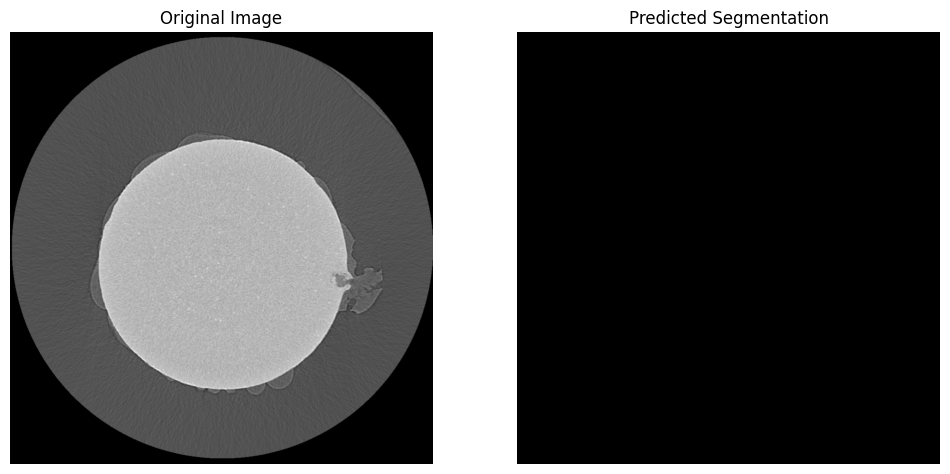

In [5]:
plot_segment_image_with_model('../dataset_test/images/img_1.png', model, device)

### Create Augmented Images to train on

In [6]:
#directories
input_img_dir = "../dataset_test/images"
input_mask_dir = "../dataset_test/masks"
output_img_dir = "../dataset_train/images"
output_mask_dir = "../dataset_train/masks"

# Parameters
n_aug_per_image = 10  # How many augmentations per original image

# Instantiate transformer
augmentor = SegmentationTransforms(image_size=(256, 256))

#Run
create_augmented_images(input_img_dir, input_mask_dir, output_img_dir, output_mask_dir, n_aug_per_image, augmentor)

Deleted all images in ../dataset_train/images
Deleted all images in ../dataset_train/masks


Augmenting: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


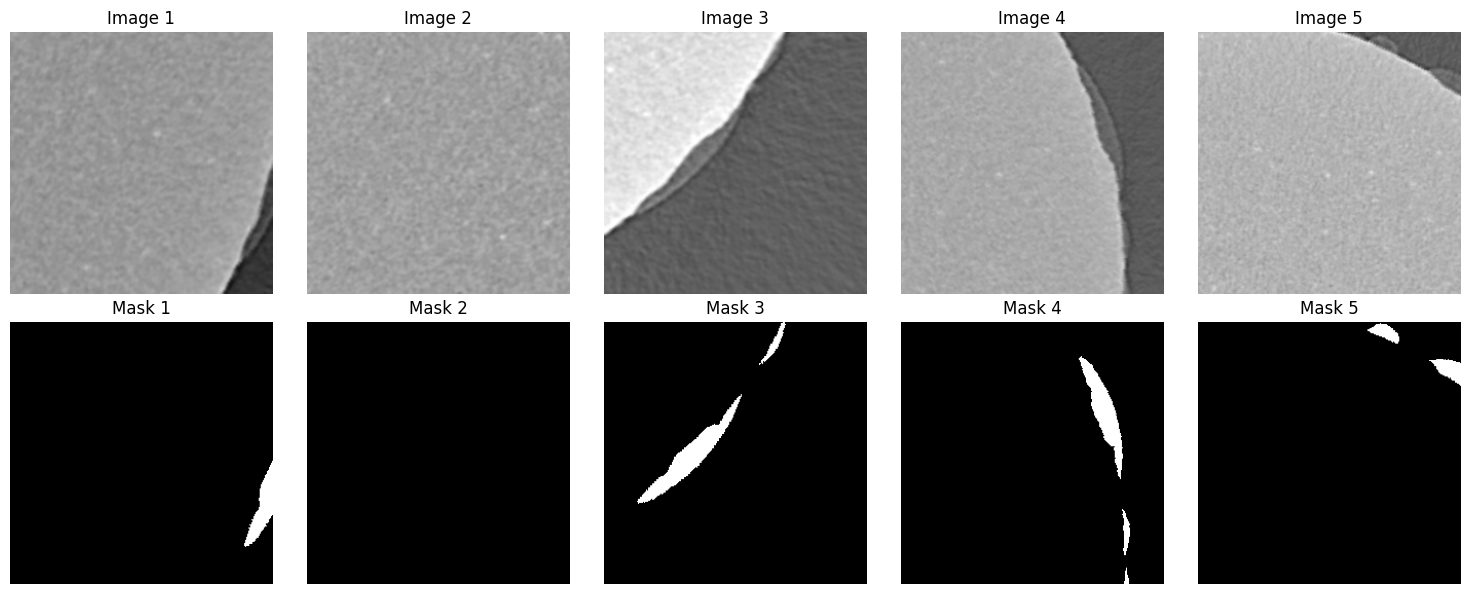

In [ ]:
#Visualise Augmented Data
show_example_training_data(output_img_dir, output_mask_dir)

### Train Model

In [8]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

num_classes = 2
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

model = model.to(device)

train_dataset = SegmentationDataset("../dataset/images", "../dataset/masks", input_transform, mask_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

train_model(epochs = 1, model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)

torch.save(model, '../models/segmentation_model_test.pth')

Epoch 1: Loss = 0.8007


In [3]:
import torchvision

torch.serialization.add_safe_globals([torchvision.models.segmentation.deeplabv3.DeepLabV3])

model = torch.load('../models/segmentation_model_full.pth', weights_only=False)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### Test Model

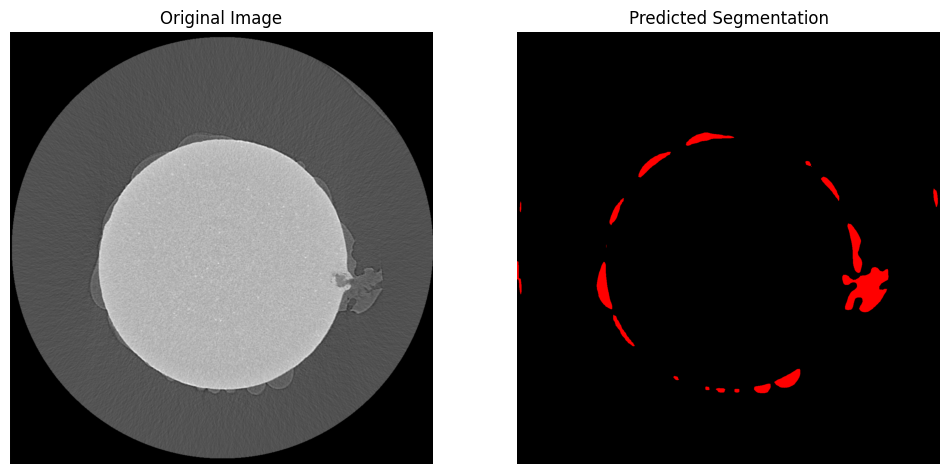

In [5]:
plot_segment_image_with_model('../dataset_test/images/img_1.png', model, device)

### Validate Model

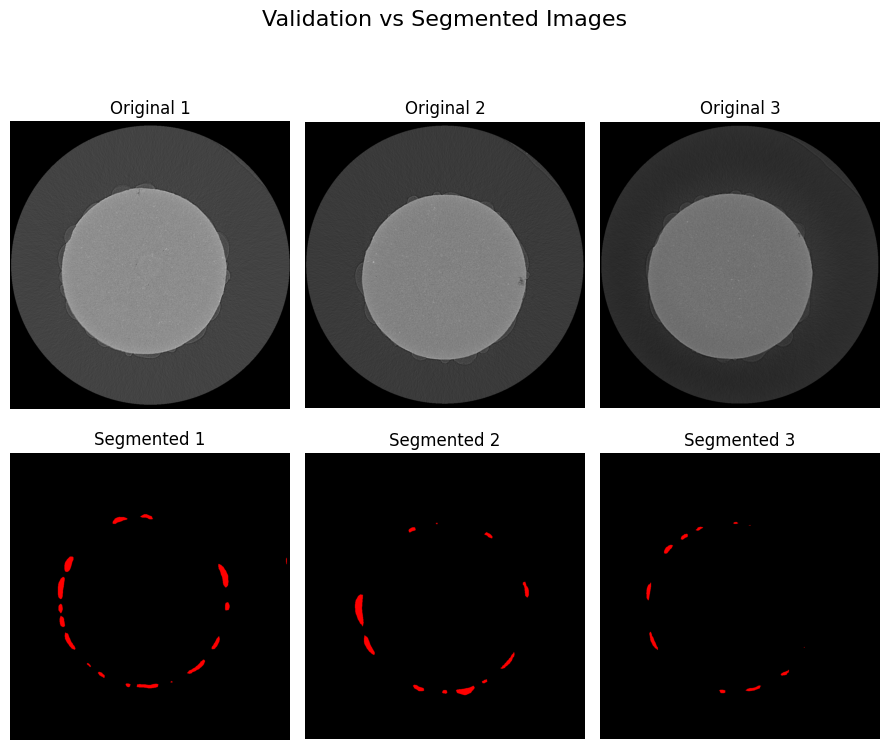

In [4]:
#Validate
plot_segmented_images("../dataset_validate/images", model, device, 3)